# Semantic segmentation

Download data

In [ ]:
!gdown https://drive.google.com/uc?id=1b5rrKIu1bwhpA0p1O2cI4SMntr-lN5eR

In [ ]:
!unzip semantic_segmentation.zip

In [ ]:
!pip3 install -r semantic_segmentation/requirements.txt

In [1]:
import torch
import os
import glob
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from PIL import Image
from torch.utils import data
import albumentations as Al
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
import random
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils import base
from torch.optim.lr_scheduler import *
from tqdm import tqdm
from torch.nn.functional import sigmoid

In [29]:
class Segmentation_dataset():
    def __init__(self,
                 imgs_path,
                 mask_path,
                 size=(512,512),
                 show = False,               
                img = 'jpg',
                mask = '_mask.gif'):
      
        self.imgs_path = imgs_path
        self.mask_path = mask_path
        self.size = size
        self.show = show
        self.img = img
        self.mask = mask
        self.data = []
        
        self.load_imgs(self.imgs_path,self.mask_path)
        
        self.transform_norm = Al.Compose([Al.Normalize(),ToTensorV2() ])
        
        self.transform = Al.Compose([Al.RandomResizedCrop(width=self.size[0],
                                                     height=self.size[1],
                                                     scale=(0.8, 1.2),
                                                     ratio=(0.8, 1.2)),
                                Al.HorizontalFlip()])
        
    def load_imgs(self,imgs_path,mask_path):
        for path in glob.glob(imgs_path + f'*.{self.img}'):
            bn = os.path.basename(path)[:-4]
            mask_path  = self.mask_path +bn +f'{self.mask}'
            
            if os.path.exists(mask_path):
                self.data.append({'img_path':path,
                                 'mask_path':mask_path})
                
    def __len__(self):
        return len(self.data)
    
    
    def augs(self,img,mask):
        
        train_transform  = self.transform(image=img, mask=mask)
        transformed_image =  train_transform["image"]
        transformed_mask =  train_transform["mask"]
        
        if self.show:
            return transformed_image,transformed_mask
          
        norm_transform  = self.transform_norm(image=transformed_image)
        transformed_image =  norm_transform["image"]    
            
        transform_mask= torch.tensor(transformed_mask,dtype=torch.float)
        transform_mask = torch.unsqueeze(transform_mask,dim=0)
        
        return transformed_image,transform_mask
        
        
    def show_img(self):
        ind = random.randint(0, self.__len__())
        img,mask = self.__getitem__(ind)
        
        plt.imshow(img)
        plt.show()
        plt.imshow(mask)
        plt.show()
        
    def __getitem__(self, index):
        
        img_path = self.data[index]['img_path']
        mask_path = self.data[index]['mask_path']
        
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        
        img  = np.array(img,dtype = np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        mask = np.array(mask,dtype = np.uint8)
        
        transform_img,transform_mask = self.augs(img,mask) 

        return transform_img,transform_mask

In [30]:
train_dataset = Segmentation_dataset(imgs_path = '/content/semantic_segmentation/imgs/',
              mask_path = '/content/semantic_segmentation/mask/',show=True)

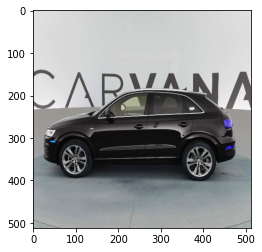

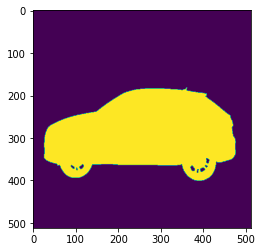

In [31]:
train_dataset.show_img()

In [32]:
train_dataset = Segmentation_dataset(imgs_path = '/content/semantic_segmentation/imgs/',
              mask_path = '/content/semantic_segmentation/mask/',size=(224, 224))

val_dataset = Segmentation_dataset(imgs_path = '/content/semantic_segmentation/val_imgs/',
              mask_path = '/content/semantic_segmentation/val_mask/',size=(224, 224))

In [11]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = None
DEVICE = 'cuda'

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1,
    activation=ACTIVATION,
)
model.to(DEVICE)

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=0.001)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4,drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4,drop_last=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
metrics = [smp.utils.metrics.IoU(threshold=0.5)]

In [14]:
class CompoundLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
         
        self.bceloss = smp.losses.soft_bce.SoftBCEWithLogitsLoss()
     
    def forward(self, y_pr, y_gt):
        return self.bceloss.forward(y_pr, y_gt)

In [15]:
losses = CompoundLoss()

In [16]:
scheduler = CosineAnnealingWarmRestarts(optimizer,5,2,verbose=True)

Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


In [17]:
torch.cuda.empty_cache()
max_score = 0
losses.to(DEVICE)
metrics[0].to(DEVICE)
for i in range(0, 30):

    vals = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

    model.train()
    for img, mask in tqdm(train_loader):
        optimizer.zero_grad()
        img, mask = img.to('cuda'), mask.to('cuda')
        out = model(img)
        mask = torch.squeeze(mask, dim=1)
        out = torch.squeeze(out,dim=1)
        loss = losses(out, mask)    
        loss.backward()       
        optimizer.step()
        out = sigmoid(out)
        metric_value = metrics[0](mask, out).cpu().detach().numpy()

        vals['train_loss'].append(loss.cpu().detach().numpy())
        vals['train_iou'].append(metric_value)

    model.eval()
    with torch.no_grad():
        for img, mask in tqdm(valid_loader):
            img, mask = img.to('cuda'), mask.to('cuda')     
            out = model(img)
            mask = torch.squeeze(mask, dim=1)
            out = torch.squeeze(out, dim=1)         
            loss_val = losses(out, mask)
            out = sigmoid(out)
            metric_value_val = metrics[0](mask, out).cpu().detach().numpy()   
                 
            vals['val_loss'].append(loss_val.cpu().detach().numpy())
            vals['val_iou'].append(metric_value_val)

    scheduler.step()




    if np.mean(vals["val_iou"]) > max_score:
        max_score = np.mean(vals["val_iou"])
        print('max--', max_score)
        torch.save(model.state_dict(), f'model_unet_resnet18.pth')

    print(f'Epoch -- {i}, '
          f'train_loss -- {np.mean(vals["train_loss"])}, '
          f'val_loss -- {np.mean(vals["val_loss"])}, '
          f'train_iou -- {np.mean(vals["train_iou"])}, '
          f'val_iou -- {np.mean(vals["val_iou"])}',
          f'max -- {max_score}'
          )

  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 15/15 [00:01<00:00, 12.03it/s]


Epoch     1: adjusting learning rate of group 0 to 9.0451e-04.
max-- 0.81578237
Epoch -- 0, train_loss -- 0.17314040660858154, val_loss -- 0.06802627444267273, train_iou -- 0.6615809202194214, val_iou -- 0.815782368183136 max -- 0.815782368183136


100%|██████████| 15/15 [00:01<00:00, 12.35it/s]


Epoch     2: adjusting learning rate of group 0 to 6.5451e-04.
max-- 0.89743805
Epoch -- 1, train_loss -- 0.05299082398414612, val_loss -- 0.031231066212058067, train_iou -- 0.8729269504547119, val_iou -- 0.8974380493164062 max -- 0.8974380493164062


100%|██████████| 15/15 [00:01<00:00, 12.24it/s]


Epoch     3: adjusting learning rate of group 0 to 3.4549e-04.
max-- 0.9251371
Epoch -- 2, train_loss -- 0.0336008220911026, val_loss -- 0.02401154488325119, train_iou -- 0.9185335636138916, val_iou -- 0.9251371026039124 max -- 0.9251371026039124


100%|██████████| 15/15 [00:01<00:00, 12.31it/s]


Epoch     4: adjusting learning rate of group 0 to 9.5492e-05.
max-- 0.9257613
Epoch -- 3, train_loss -- 0.02834453247487545, val_loss -- 0.026408905163407326, train_iou -- 0.9327651262283325, val_iou -- 0.9257612824440002 max -- 0.9257612824440002


100%|██████████| 15/15 [00:01<00:00, 12.42it/s]


Epoch     5: adjusting learning rate of group 0 to 1.0000e-03.
max-- 0.93517965
Epoch -- 4, train_loss -- 0.024906061589717865, val_loss -- 0.021212948486208916, train_iou -- 0.9394327998161316, val_iou -- 0.9351796507835388 max -- 0.9351796507835388


100%|██████████| 15/15 [00:01<00:00, 12.25it/s]


Epoch     6: adjusting learning rate of group 0 to 9.7553e-04.
max-- 0.93587977
Epoch -- 5, train_loss -- 0.027515942230820656, val_loss -- 0.024505509063601494, train_iou -- 0.9381006956100464, val_iou -- 0.9358797669410706 max -- 0.9358797669410706


100%|██████████| 15/15 [00:01<00:00, 12.51it/s]


Epoch     7: adjusting learning rate of group 0 to 9.0451e-04.
max-- 0.94608915
Epoch -- 6, train_loss -- 0.0235100407153368, val_loss -- 0.01898130401968956, train_iou -- 0.9471226930618286, val_iou -- 0.9460891485214233 max -- 0.9460891485214233


100%|██████████| 15/15 [00:01<00:00, 12.52it/s]


Epoch     8: adjusting learning rate of group 0 to 7.9389e-04.
max-- 0.95033336
Epoch -- 7, train_loss -- 0.021874673664569855, val_loss -- 0.019282007589936256, train_iou -- 0.9511661529541016, val_iou -- 0.9503333568572998 max -- 0.9503333568572998


100%|██████████| 15/15 [00:01<00:00, 12.40it/s]


Epoch     9: adjusting learning rate of group 0 to 6.5451e-04.
max-- 0.9532425
Epoch -- 8, train_loss -- 0.02034437656402588, val_loss -- 0.016747426241636276, train_iou -- 0.9549543857574463, val_iou -- 0.9532424807548523 max -- 0.9532424807548523


100%|██████████| 15/15 [00:01<00:00, 12.27it/s]


Epoch    10: adjusting learning rate of group 0 to 5.0000e-04.
max-- 0.95801604
Epoch -- 9, train_loss -- 0.016932694241404533, val_loss -- 0.016605811193585396, train_iou -- 0.9614076614379883, val_iou -- 0.958016037940979 max -- 0.958016037940979


100%|██████████| 15/15 [00:01<00:00, 12.84it/s]


Epoch    11: adjusting learning rate of group 0 to 3.4549e-04.
max-- 0.95978385
Epoch -- 10, train_loss -- 0.015294121578335762, val_loss -- 0.01568576879799366, train_iou -- 0.9649580717086792, val_iou -- 0.9597838521003723 max -- 0.9597838521003723


100%|██████████| 15/15 [00:01<00:00, 12.27it/s]


Epoch    12: adjusting learning rate of group 0 to 2.0611e-04.
max-- 0.9621074
Epoch -- 11, train_loss -- 0.014419777318835258, val_loss -- 0.014988801442086697, train_iou -- 0.9672878980636597, val_iou -- 0.9621074199676514 max -- 0.9621074199676514


100%|██████████| 15/15 [00:01<00:00, 12.57it/s]


Epoch    13: adjusting learning rate of group 0 to 9.5492e-05.
max-- 0.9624221
Epoch -- 12, train_loss -- 0.013536211103200912, val_loss -- 0.01535497885197401, train_iou -- 0.968730628490448, val_iou -- 0.9624220728874207 max -- 0.9624220728874207


100%|██████████| 15/15 [00:01<00:00, 12.25it/s]


Epoch    14: adjusting learning rate of group 0 to 2.4472e-05.
max-- 0.9628965
Epoch -- 13, train_loss -- 0.013107912614941597, val_loss -- 0.015106947161257267, train_iou -- 0.9697853922843933, val_iou -- 0.9628965258598328 max -- 0.9628965258598328


100%|██████████| 15/15 [00:01<00:00, 12.31it/s]


Epoch    15: adjusting learning rate of group 0 to 1.0000e-03.
max-- 0.96385497
Epoch -- 14, train_loss -- 0.012959549203515053, val_loss -- 0.014452120289206505, train_iou -- 0.9701035618782043, val_iou -- 0.963854968547821 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.66it/s]


Epoch    16: adjusting learning rate of group 0 to 9.9384e-04.
Epoch -- 15, train_loss -- 0.021800773218274117, val_loss -- 0.3969002962112427, train_iou -- 0.9574019312858582, val_iou -- 0.7515427470207214 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.23it/s]


Epoch    17: adjusting learning rate of group 0 to 9.7553e-04.
Epoch -- 16, train_loss -- 0.03016841784119606, val_loss -- 0.024129893630743027, train_iou -- 0.9366944432258606, val_iou -- 0.9436368346214294 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.60it/s]


Epoch    18: adjusting learning rate of group 0 to 9.4550e-04.
Epoch -- 17, train_loss -- 0.020668065175414085, val_loss -- 0.018485207110643387, train_iou -- 0.9552720189094543, val_iou -- 0.9522846341133118 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.45it/s]


Epoch    19: adjusting learning rate of group 0 to 9.0451e-04.
Epoch -- 18, train_loss -- 0.018524659797549248, val_loss -- 0.020359184592962265, train_iou -- 0.9593903422355652, val_iou -- 0.9542338252067566 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.66it/s]


Epoch    20: adjusting learning rate of group 0 to 8.5355e-04.
Epoch -- 19, train_loss -- 0.06279122084379196, val_loss -- 0.17335157096385956, train_iou -- 0.8949310779571533, val_iou -- 0.7650172114372253 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.44it/s]


Epoch    21: adjusting learning rate of group 0 to 7.9389e-04.
Epoch -- 20, train_loss -- 0.03623468428850174, val_loss -- 0.024723326787352562, train_iou -- 0.9220200777053833, val_iou -- 0.9316107630729675 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.58it/s]


Epoch    22: adjusting learning rate of group 0 to 7.2700e-04.
Epoch -- 21, train_loss -- 0.02699793502688408, val_loss -- 0.020888231694698334, train_iou -- 0.9423602223396301, val_iou -- 0.943603515625 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.42it/s]


Epoch    23: adjusting learning rate of group 0 to 6.5451e-04.
Epoch -- 22, train_loss -- 0.02145293541252613, val_loss -- 0.017562231048941612, train_iou -- 0.9520986080169678, val_iou -- 0.950534999370575 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.35it/s]


Epoch    24: adjusting learning rate of group 0 to 5.7822e-04.
Epoch -- 23, train_loss -- 0.019850656390190125, val_loss -- 0.019037051126360893, train_iou -- 0.9571030139923096, val_iou -- 0.9522361159324646 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.20it/s]


Epoch    25: adjusting learning rate of group 0 to 5.0000e-04.
Epoch -- 24, train_loss -- 0.01920737512409687, val_loss -- 0.01938983052968979, train_iou -- 0.9582657217979431, val_iou -- 0.9520496129989624 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.57it/s]


Epoch    26: adjusting learning rate of group 0 to 4.2178e-04.
Epoch -- 25, train_loss -- 0.01752520725131035, val_loss -- 0.01537388190627098, train_iou -- 0.9616281986236572, val_iou -- 0.9590989351272583 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.52it/s]


Epoch    27: adjusting learning rate of group 0 to 3.4549e-04.
Epoch -- 26, train_loss -- 0.017004963010549545, val_loss -- 0.01819736696779728, train_iou -- 0.9629632234573364, val_iou -- 0.9552351832389832 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.37it/s]


Epoch    28: adjusting learning rate of group 0 to 2.7300e-04.
Epoch -- 27, train_loss -- 0.016378220170736313, val_loss -- 0.018626779317855835, train_iou -- 0.9638960957527161, val_iou -- 0.9566519856452942 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.29it/s]


Epoch    29: adjusting learning rate of group 0 to 2.0611e-04.
Epoch -- 28, train_loss -- 0.015674542635679245, val_loss -- 0.0175179373472929, train_iou -- 0.9656256437301636, val_iou -- 0.9583032131195068 max -- 0.963854968547821


100%|██████████| 15/15 [00:01<00:00, 12.33it/s]

Epoch    30: adjusting learning rate of group 0 to 1.4645e-04.
Epoch -- 29, train_loss -- 0.015744930133223534, val_loss -- 0.017361951991915703, train_iou -- 0.9657331109046936, val_iou -- 0.9589786529541016 max -- 0.963854968547821


Inference

In [18]:
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1,
    activation=ACTIVATION,
)
model.to(DEVICE)
model.load_state_dict(torch.load('model_unet_resnet18.pth'))
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [19]:
demo_transform = Al.Compose([
                             Al.Normalize(),
                             ToTensorV2()])

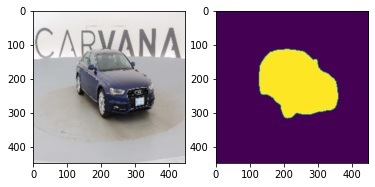

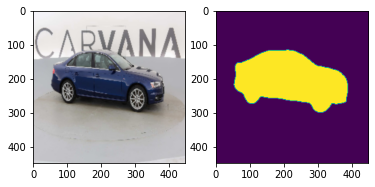

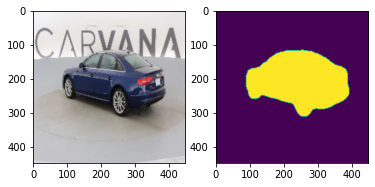

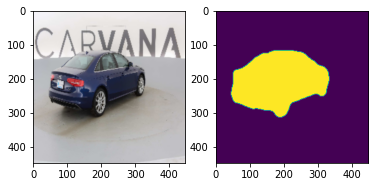

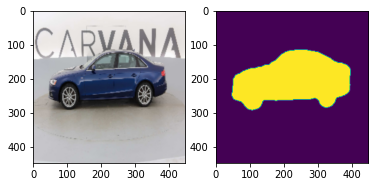

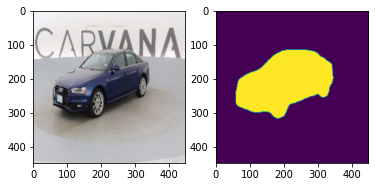

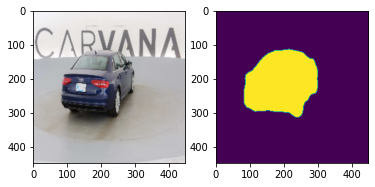

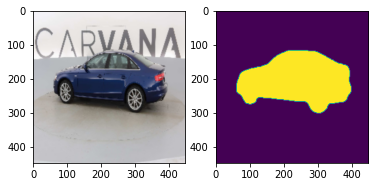

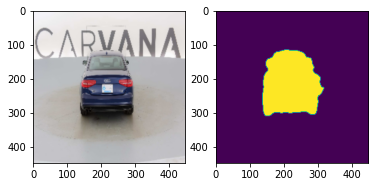

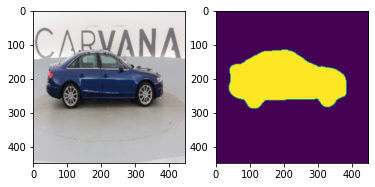

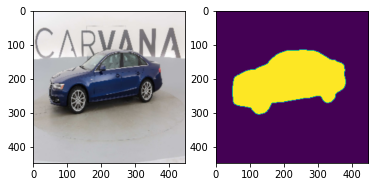

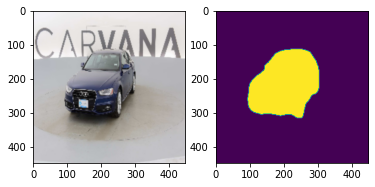

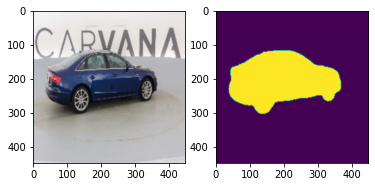

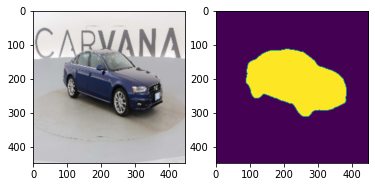

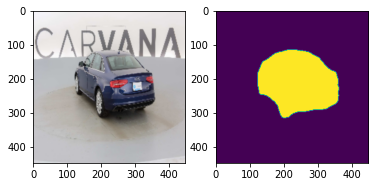

In [20]:
threshhold = 0.3
for path in glob.glob('/content/semantic_segmentation/val_imgs/*.jpg'):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    res_img = cv2.resize(img,(224,224))
    transform = demo_transform(image = res_img)
    transformed_img = transform['image']
    transformed_img = torch.unsqueeze(transformed_img, dim=0)
    with torch.no_grad():
        out = model(transformed_img.to(DEVICE))
        out = sigmoid(out)
        out = out.squeeze().cpu().detach().numpy()
        out[out>=threshhold] = 255
        out[out<threshhold] = 0
        
        
        axes[0].imshow(cv2.resize(res_img,(448,448)))
        axes[1].imshow(cv2.resize(out,(448,448)))
        
        fig.show()

train with new loss and model

In [21]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = None
DEVICE = 'cuda'

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=1,
    activation=ACTIVATION,
)
model.to(DEVICE)

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=0.001)

In [22]:
class CompoundLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        

        self.jac = smp.losses.JaccardLoss(mode='binary',from_logits=True)
        self.focal = smp.losses.FocalLoss(mode='binary')

    def forward(self, y_pr, y_gt):
      
        focal = self.focal.forward(y_pr, y_gt)
        jac = self.jac.forward(y_pr, y_gt)
 
        return 0.3 * focal + 0.7 * jac

In [23]:
losses = CompoundLoss()
scheduler = CosineAnnealingWarmRestarts(optimizer,5,2,verbose=True)
torch.cuda.empty_cache()
max_score = 0
losses.to(DEVICE)
metrics[0].to(DEVICE)
for i in range(0, 30):

    vals = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

    model.train()
    for img, mask in tqdm(train_loader):
        optimizer.zero_grad()
        img, mask = img.to('cuda'), mask.to('cuda')
        out = model(img)
        mask = torch.squeeze(mask, dim=1)
        out = torch.squeeze(out,dim=1)
        loss = losses(out, mask)
        loss.backward()
        optimizer.step()
        out = sigmoid(out)
        metric_value = metrics[0](mask, out).cpu().detach().numpy()
        
        vals['train_loss'].append(loss.cpu().detach().numpy())
        vals['train_iou'].append(metric_value)

    model.eval()
    with torch.no_grad():
        for img, mask in tqdm(valid_loader):
            img, mask = img.to('cuda'), mask.to('cuda')
            out = model(img)
            mask = torch.squeeze(mask, dim=1)
            out = torch.squeeze(out, dim=1)
            loss_val = losses(out, mask)
            out = sigmoid(out)
            metric_value_val = metrics[0](mask, out).cpu().detach().numpy()

            vals['val_loss'].append(loss_val.cpu().detach().numpy())
            vals['val_iou'].append(metric_value_val)

    scheduler.step()




    if np.mean(vals["val_iou"]) > max_score:
        max_score = np.mean(vals["val_iou"])
        print('max--', max_score)
        torch.save(model.state_dict(), f'model_d3plus_resnet18.pth')

    print(f'Epoch -- {i}, '
          f'train_loss -- {np.mean(vals["train_loss"])}, '
          f'val_loss -- {np.mean(vals["val_loss"])}, '
          f'train_iou -- {np.mean(vals["train_iou"])}, '
          f'val_iou -- {np.mean(vals["val_iou"])}',
          f'max -- {max_score}'
          )

Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 15/15 [00:01<00:00, 11.96it/s]


Epoch     1: adjusting learning rate of group 0 to 9.0451e-04.
max-- 0.8519943
Epoch -- 0, train_loss -- 0.20768164098262787, val_loss -- 0.1113075539469719, train_iou -- 0.72597336769104, val_iou -- 0.8519942760467529 max -- 0.8519942760467529


100%|██████████| 15/15 [00:01<00:00, 12.43it/s]


Epoch     2: adjusting learning rate of group 0 to 6.5451e-04.
max-- 0.93737197
Epoch -- 1, train_loss -- 0.06927014887332916, val_loss -- 0.047416556626558304, train_iou -- 0.9118707180023193, val_iou -- 0.9373719692230225 max -- 0.9373719692230225


100%|██████████| 15/15 [00:01<00:00, 12.59it/s]


Epoch     3: adjusting learning rate of group 0 to 3.4549e-04.
max-- 0.9490654
Epoch -- 2, train_loss -- 0.04555244371294975, val_loss -- 0.03981754556298256, train_iou -- 0.9430443644523621, val_iou -- 0.9490653872489929 max -- 0.9490653872489929


100%|██████████| 15/15 [00:01<00:00, 12.45it/s]


Epoch     4: adjusting learning rate of group 0 to 9.5492e-05.
max-- 0.9555565
Epoch -- 3, train_loss -- 0.038039904087781906, val_loss -- 0.034427888691425323, train_iou -- 0.9527180790901184, val_iou -- 0.9555565118789673 max -- 0.9555565118789673


100%|██████████| 15/15 [00:01<00:00, 12.39it/s]


Epoch     5: adjusting learning rate of group 0 to 1.0000e-03.
max-- 0.95685935
Epoch -- 4, train_loss -- 0.03492607921361923, val_loss -- 0.03367212042212486, train_iou -- 0.9564944505691528, val_iou -- 0.9568593502044678 max -- 0.9568593502044678


100%|██████████| 15/15 [00:01<00:00, 12.20it/s]


Epoch     6: adjusting learning rate of group 0 to 9.7553e-04.
Epoch -- 5, train_loss -- 0.03870387375354767, val_loss -- 0.04167214781045914, train_iou -- 0.9533412456512451, val_iou -- 0.9505031108856201 max -- 0.9568593502044678


100%|██████████| 15/15 [00:01<00:00, 12.44it/s]


Epoch     7: adjusting learning rate of group 0 to 9.0451e-04.
Epoch -- 6, train_loss -- 0.03578828275203705, val_loss -- 0.04008595272898674, train_iou -- 0.9570673704147339, val_iou -- 0.9510184526443481 max -- 0.9568593502044678


100%|██████████| 15/15 [00:01<00:00, 12.52it/s]


Epoch     8: adjusting learning rate of group 0 to 7.9389e-04.
max-- 0.9603168
Epoch -- 7, train_loss -- 0.030835799872875214, val_loss -- 0.032711662352085114, train_iou -- 0.9628598093986511, val_iou -- 0.9603167772293091 max -- 0.9603167772293091


100%|██████████| 15/15 [00:01<00:00, 12.10it/s]


Epoch     9: adjusting learning rate of group 0 to 6.5451e-04.
max-- 0.9644357
Epoch -- 8, train_loss -- 0.026998251676559448, val_loss -- 0.02885327860713005, train_iou -- 0.9673748016357422, val_iou -- 0.9644356966018677 max -- 0.9644356966018677


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


Epoch    10: adjusting learning rate of group 0 to 5.0000e-04.
max-- 0.96535337
Epoch -- 9, train_loss -- 0.02479403465986252, val_loss -- 0.027957774698734283, train_iou -- 0.9698841571807861, val_iou -- 0.9653533697128296 max -- 0.9653533697128296


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


Epoch    11: adjusting learning rate of group 0 to 3.4549e-04.
max-- 0.9678741
Epoch -- 10, train_loss -- 0.023518063127994537, val_loss -- 0.026018599048256874, train_iou -- 0.9715632200241089, val_iou -- 0.9678741097450256 max -- 0.9678741097450256


100%|██████████| 15/15 [00:01<00:00, 12.47it/s]


Epoch    12: adjusting learning rate of group 0 to 2.0611e-04.
max-- 0.9680484
Epoch -- 11, train_loss -- 0.022615846246480942, val_loss -- 0.025999421253800392, train_iou -- 0.9725977778434753, val_iou -- 0.9680483937263489 max -- 0.9680483937263489


100%|██████████| 15/15 [00:01<00:00, 12.56it/s]


Epoch    13: adjusting learning rate of group 0 to 9.5492e-05.
max-- 0.9683693
Epoch -- 12, train_loss -- 0.021457873284816742, val_loss -- 0.02590460702776909, train_iou -- 0.9738991260528564, val_iou -- 0.9683693051338196 max -- 0.9683693051338196


100%|██████████| 15/15 [00:01<00:00, 12.40it/s]


Epoch    14: adjusting learning rate of group 0 to 2.4472e-05.
Epoch -- 13, train_loss -- 0.02090262994170189, val_loss -- 0.026453422382473946, train_iou -- 0.9744818806648254, val_iou -- 0.9678558111190796 max -- 0.9683693051338196


100%|██████████| 15/15 [00:01<00:00, 12.42it/s]


Epoch    15: adjusting learning rate of group 0 to 1.0000e-03.
Epoch -- 14, train_loss -- 0.02078763023018837, val_loss -- 0.02663300186395645, train_iou -- 0.9746377468109131, val_iou -- 0.9676929712295532 max -- 0.9683693051338196


100%|██████████| 15/15 [00:01<00:00, 12.32it/s]


Epoch    16: adjusting learning rate of group 0 to 9.9384e-04.
Epoch -- 15, train_loss -- 0.02409866638481617, val_loss -- 0.03334911912679672, train_iou -- 0.9714257717132568, val_iou -- 0.9608829617500305 max -- 0.9683693051338196


100%|██████████| 15/15 [00:01<00:00, 12.14it/s]


Epoch    17: adjusting learning rate of group 0 to 9.7553e-04.
Epoch -- 16, train_loss -- 0.025277897715568542, val_loss -- 0.030735142529010773, train_iou -- 0.97006756067276, val_iou -- 0.963837742805481 max -- 0.9683693051338196


100%|██████████| 15/15 [00:01<00:00, 12.56it/s]


Epoch    18: adjusting learning rate of group 0 to 9.4550e-04.
Epoch -- 17, train_loss -- 0.02307341806590557, val_loss -- 0.0273517444729805, train_iou -- 0.9725543260574341, val_iou -- 0.967187762260437 max -- 0.9683693051338196


100%|██████████| 15/15 [00:01<00:00, 12.77it/s]


Epoch    19: adjusting learning rate of group 0 to 9.0451e-04.
Epoch -- 18, train_loss -- 0.022385817021131516, val_loss -- 0.026280827820301056, train_iou -- 0.9733238220214844, val_iou -- 0.9682998657226562 max -- 0.9683693051338196


100%|██████████| 15/15 [00:01<00:00, 12.50it/s]


Epoch    20: adjusting learning rate of group 0 to 8.5355e-04.
max-- 0.9694851
Epoch -- 19, train_loss -- 0.022188283503055573, val_loss -- 0.025911467149853706, train_iou -- 0.9737784266471863, val_iou -- 0.9694851040840149 max -- 0.9694851040840149


100%|██████████| 15/15 [00:01<00:00, 12.34it/s]


Epoch    21: adjusting learning rate of group 0 to 7.9389e-04.
max-- 0.96957237
Epoch -- 20, train_loss -- 0.02122744359076023, val_loss -- 0.025613009929656982, train_iou -- 0.9747548699378967, val_iou -- 0.9695723652839661 max -- 0.9695723652839661


100%|██████████| 15/15 [00:01<00:00, 12.67it/s]


Epoch    22: adjusting learning rate of group 0 to 7.2700e-04.
Epoch -- 21, train_loss -- 0.02010631561279297, val_loss -- 0.027271417900919914, train_iou -- 0.9760210514068604, val_iou -- 0.9676416516304016 max -- 0.9695723652839661


100%|██████████| 15/15 [00:01<00:00, 12.57it/s]


Epoch    23: adjusting learning rate of group 0 to 6.5451e-04.
Epoch -- 22, train_loss -- 0.019553231075406075, val_loss -- 0.028802698478102684, train_iou -- 0.9767192006111145, val_iou -- 0.9663704633712769 max -- 0.9695723652839661


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


Epoch    24: adjusting learning rate of group 0 to 5.7822e-04.
max-- 0.971543
Epoch -- 23, train_loss -- 0.017920412123203278, val_loss -- 0.023999126628041267, train_iou -- 0.978540301322937, val_iou -- 0.97154301404953 max -- 0.97154301404953


100%|██████████| 15/15 [00:01<00:00, 12.42it/s]


Epoch    25: adjusting learning rate of group 0 to 5.0000e-04.
Epoch -- 24, train_loss -- 0.017452873289585114, val_loss -- 0.024097081273794174, train_iou -- 0.9791224598884583, val_iou -- 0.9713114500045776 max -- 0.97154301404953


100%|██████████| 15/15 [00:01<00:00, 12.64it/s]


Epoch    26: adjusting learning rate of group 0 to 4.2178e-04.
max-- 0.9715474
Epoch -- 25, train_loss -- 0.016934428364038467, val_loss -- 0.024192925542593002, train_iou -- 0.9797360301017761, val_iou -- 0.9715474247932434 max -- 0.9715474247932434


100%|██████████| 15/15 [00:01<00:00, 12.48it/s]


Epoch    27: adjusting learning rate of group 0 to 3.4549e-04.
Epoch -- 26, train_loss -- 0.016627846285700798, val_loss -- 0.026350893080234528, train_iou -- 0.9800803661346436, val_iou -- 0.9695578217506409 max -- 0.9715474247932434


100%|██████████| 15/15 [00:01<00:00, 12.66it/s]


Epoch    28: adjusting learning rate of group 0 to 2.7300e-04.
Epoch -- 27, train_loss -- 0.015804750844836235, val_loss -- 0.024959973990917206, train_iou -- 0.9810073375701904, val_iou -- 0.9711378812789917 max -- 0.9715474247932434


100%|██████████| 15/15 [00:01<00:00, 12.18it/s]


Epoch    29: adjusting learning rate of group 0 to 2.0611e-04.
max-- 0.9724215
Epoch -- 28, train_loss -- 0.01544969156384468, val_loss -- 0.023494606837630272, train_iou -- 0.9813807010650635, val_iou -- 0.9724215269088745 max -- 0.9724215269088745


100%|██████████| 15/15 [00:01<00:00, 12.45it/s]

Epoch    30: adjusting learning rate of group 0 to 1.4645e-04.
Epoch -- 29, train_loss -- 0.015116012655198574, val_loss -- 0.02384757809340954, train_iou -- 0.9817456007003784, val_iou -- 0.9722194075584412 max -- 0.9724215269088745


# Instance segmentation

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

In [34]:
!gdown https://drive.google.com/uc?id=1sJVtubSrJYk_S0QtVniq3Cfp-UBD6f2d

Downloading...
From: https://drive.google.com/uc?id=1sJVtubSrJYk_S0QtVniq3Cfp-UBD6f2d
To: /content/instance.zip
100% 15.8M/15.8M [00:00<00:00, 50.3MB/s]


In [ ]:
!unzip instance.zip

In [59]:
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import cv2
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode
import os
from shutil import copyfile
from natsort import natsorted
import glob
import json
import random
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [60]:
def get_dolp_dicts(img_dir, js_path):
    with open(js_path) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, img_name in enumerate(imgs_anns):
        record = {}
        filename = imgs_anns[img_name]['filename']

        img_path = os.path.join(img_dir, filename)
        if os.path.exists(img_path):
            height, width = cv2.imread(img_path).shape[:2]

            record["file_name"] = img_path
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width

            objs = []
            for region in imgs_anns[img_name]['regions']:
                all_points_x = region['shape_attributes']['all_points_x']
                all_points_y = region['shape_attributes']['all_points_y']

                poly = [(x, y) for x, y in zip(all_points_x, all_points_y)]

                poly = [p for x in poly for p in x]

                obj = {
                    "bbox": [np.min(all_points_x), np.min(all_points_y), np.max(all_points_x), np.max(all_points_y)],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": 0,
                }
                objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        else:
            continue

    return dataset_dicts

In [61]:
dataset_path = '/content/instance/'

In [64]:
json_path = '/content/instance/BELOW_LABELS.json'
for d in ["train", "val"]:
    DatasetCatalog.register("Dolphin_" + d, lambda d=d: get_dolp_dicts(os.path.join(dataset_path, d), json_path))
    MetadataCatalog.get("Dolphin_" + d).set(thing_classes=["Dolphin"])
dolphin_metadata = MetadataCatalog.get("Dolphin_train")

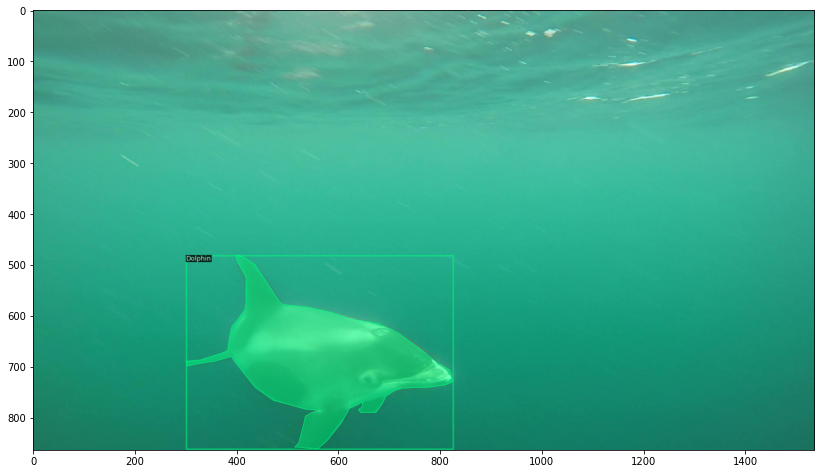

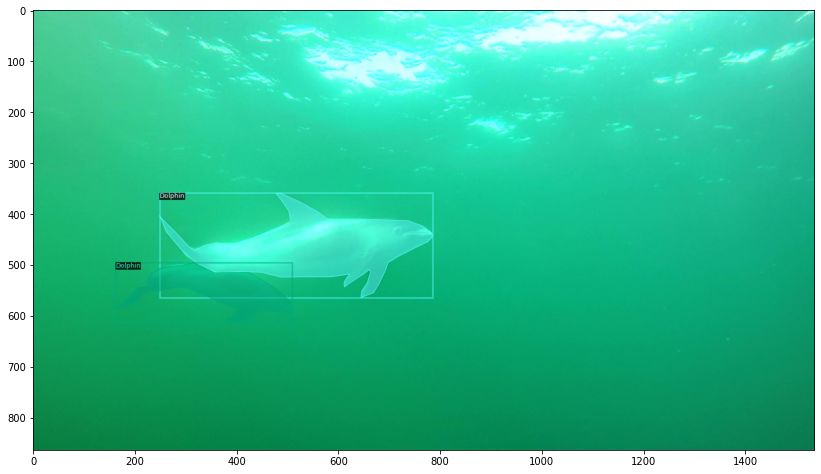

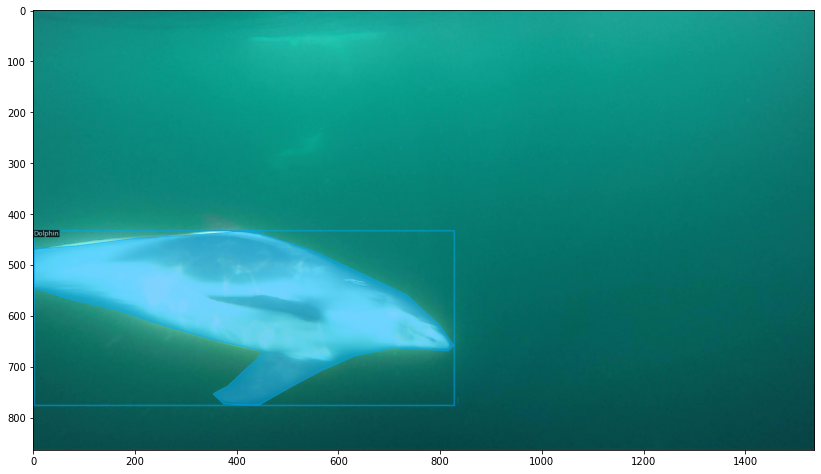

In [65]:
dataset_dicts = get_dolp_dicts(os.path.join(dataset_path, 'train'), json_path)
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    v = Visualizer(im[:, :, ::-1], metadata=dolphin_metadata, scale=0.8)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [67]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Dolphin_train",)
cfg.DATASETS.TEST = ("Dolphin_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 100
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (Dolphin)
cfg.TEST.EVAL_PERIOD = 25

In [68]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, output_dir=cfg.OUTPUT_DIR)



trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/23 16:30:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[10/23 16:30:58 d2.engine.train_loop]: Starting training from iteration 0
[10/23 16:31:42 d2.utils.events]:  eta: 0:02:55  iter: 19  total_loss: 2.12  loss_cls: 0.6816  loss_box_reg: 0.7318  loss_mask: 0.683  loss_rpn_cls: 0.006034  loss_rpn_loc: 0.00712  time: 2.1729  data_time: 0.0587  lr: 4.7703e-05  max_mem: 4675M
[10/23 16:31:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/23 16:31:54 d2.data.common]: Serializing 52 elements to byte tensors and concatenating them all ...
[10/23 16:31:54 d2.data.common]: Serialized dataset takes 0.04 MiB
[10/23 16:31:54 d2.evaluation.coco_evaluation]: 'Dolphin_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[10/23 16:31:54 d2.data.datasets.coco]: Converting annotations of dataset 'Dolphin_val' to COCO format ...)
[10/23 16:31:55 d2.data.datasets.coco]: Converting dataset dic

inference


In [69]:
weights = "/content/output/model_final.pth"
cfg.MODEL.WEIGHTS = weights  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

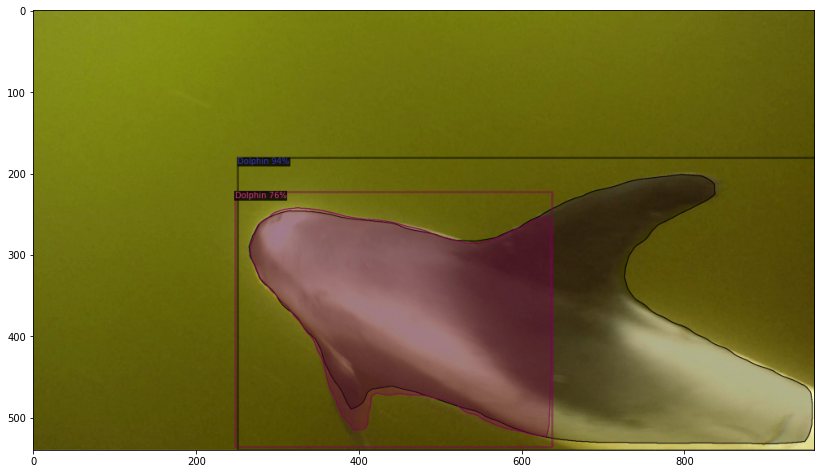

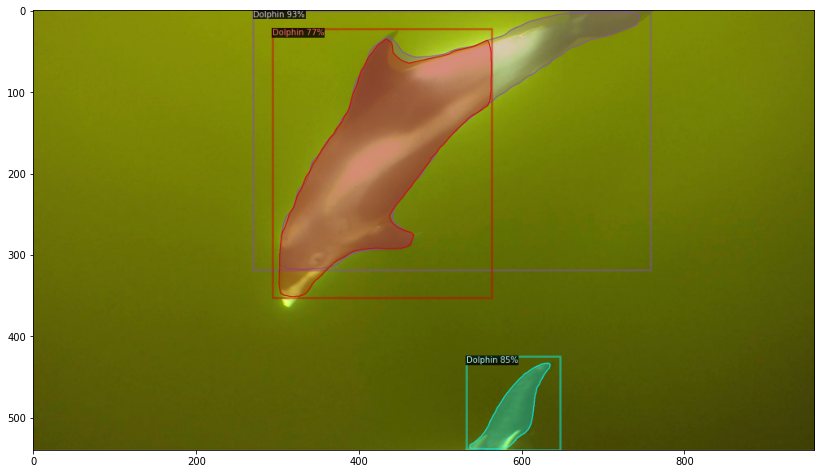

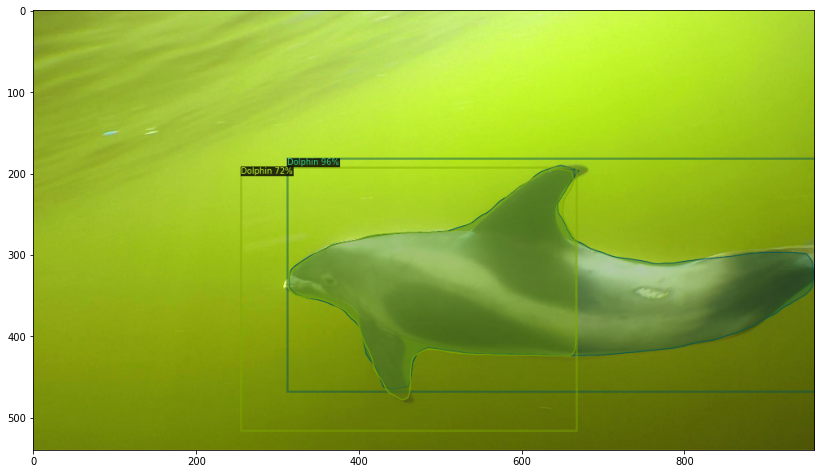

In [71]:
dataset_dicts = get_dolp_dicts("/content/instance/val/", json_path)
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=dolphin_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
                   # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(14, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [72]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("Dolphin_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "Dolphin_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[10/23 16:40:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/23 16:40:34 d2.data.common]: Serializing 52 elements to byte tensors and concatenating them all ...
[10/23 16:40:34 d2.data.common]: Serialized dataset takes 0.04 MiB
[10/23 16:40:34 d2.evaluation.evaluator]: Start inference on 52 batches
[10/23 16:40:39 d2.evaluation.evaluator]: Inference done 11/52. Dataloading: 0.0011 s/iter. Inference: 0.3554 s/iter. Eval: 0.0084 s/iter. Total: 0.3650 s/iter. ETA=0:00:14
[10/23 16:40:44 d2.evaluation.evaluator]: Inference done 25/52. Dataloading: 0.0023 s/iter. Inference: 0.3534 s/iter. Eval: 0.0092 s/iter. Total: 0.3652 s/iter. ETA=0:00:09
[10/23 16:40:50 d2.evaluation.evaluator]: Inference done 39/52. Dataloading: 0.0024 s/iter. Inference: 0.3537 s/iter. Eval: 0.0096 s/iter. Total: 0.3658 s/iter. ETA=0:00:04
[10/23 16:40:54 d2.evaluation.evaluator]: Total inference t